In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/sample_submission.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/train.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [3]:
train_df = pd.read_csv('/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/train.csv')
test_df = pd.read_csv('/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/test.csv')

In [4]:
train_df.shape

(29500, 14)

In [5]:
test_df.shape

(7000, 13)

In [6]:
train_df.head(5)

,id,adults,children,weekends,weekdays,meal_type,room_type,arrival,lead_time,segment,repeat,price,requests,booking_status
0,0,2,0,0,1,Not Selected,Room_Type 1,2018-05-21,54.0,Online,0,116.10,0,1
1,1,1,0,3,6,Not Selected,Room_Type 1,2018-11-12,12.0,Online,0,71.87,1,1
2,2,2,0,0,2,Meal Plan 1,Room_Type 2,2018-01-06,34.0,Online,0,71.55,1,0
3,3,1,0,2,1,Meal Plan 1,Room_Type 1,2018-02-14,4.0,Corporate,1,66.00,0,0
4,4,2,0,2,3,Meal Plan 1,Room_Type 1,2018-07-08,155.0,Offline,0,72.25,0,0


In [7]:
test_df.head(5)

,id,adults,children,weekends,weekdays,meal_type,room_type,arrival,lead_time,segment,repeat,price,requests
0,0,2,1,1,0,Meal Plan 1,NaN,2017-08-23,3.0,Online,0,90.00,3
1,1,2,0,1,2,Meal Plan 1,Room_Type 4,2018-02-12,9.0,Offline,0,48.67,0
2,2,2,0,2,2,Meal Plan 1,Room_Type 1,2018-12-25,24.0,Online,0,95.20,1
3,3,2,0,0,3,Meal Plan 1,NaN,2018-06-21,23.0,Online,0,127.67,0
4,4,2,1,0,2,Meal Plan 1,Room_Type 4,2018-09-08,9.0,Online,0,201.50,2


In [8]:
train_df['room_type'].unique()

array(['Room_Type 1', 'Room_Type 2', 'Room_Type 4', nan, 'Room_Type 6',
       'Room_Type 5', 'Room_Type 7', 'Room_Type 3'], dtype=object)

In [9]:
train_df['meal_type'].unique()

array(['Not Selected', 'Meal Plan 1', 'Meal Plan 2', 'Meal Plan 3'],
      dtype=object)

In [10]:
train_df['arrival'].nunique()

550

### Different data types in  the columns.

In [11]:
train_df.dtypes

id                  int64
adults              int64
children            int64
weekends            int64
weekdays            int64
meal_type          object
room_type          object
arrival            object
lead_time         float64
segment            object
repeat              int64
price             float64
requests            int64
booking_status      int64
dtype: object

In [12]:
test_df.dtypes

id             int64
adults         int64
children       int64
weekends       int64
weekdays       int64
meal_type     object
room_type     object
arrival       object
lead_time    float64
segment       object
repeat         int64
price        float64
requests       int64
dtype: object

#### Train set
**Out of 13 features excluding 'id' 4 are categorical whereas the remaining 9 are numerical variables.**

### Description of the dataset.

In [13]:
train_df.describe(include=[np.number])

,id,adults,children,weekends,weekdays,lead_time,repeat,price,requests,booking_status
count,29500.000000,29500.000000,29500.000000,29500.000000,29500.000000,27805.000000,29500.000000,27917.000000,29500.000000,29500.000000
mean,14749.500000,1.843559,0.106576,0.808136,2.202237,85.405431,0.026000,103.483304,0.619661,0.326441
std,8516.060807,0.518711,0.405517,0.868835,1.404200,85.939750,0.159138,35.120922,0.785919,0.468919
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7374.750000,2.000000,0.000000,0.000000,1.000000,17.000000,0.000000,80.500000,0.000000,0.000000
50%,14749.500000,2.000000,0.000000,1.000000,2.000000,58.000000,0.000000,99.880000,0.000000,0.000000
75%,22124.250000,2.000000,0.000000,2.000000,3.000000,127.000000,0.000000,120.180000,1.000000,1.000000
max,29499.000000,4.000000,10.000000,6.000000,17.000000,443.000000,1.000000,375.500000,5.000000,1.000000


In [14]:
test_df.describe()

,id,adults,children,weekends,weekdays,lead_time,repeat,price,requests
count,7000.000000,7000.000000,7000.000000,7000.000000,7000.000000,6588.000000,7000.000000,6594.000000,7000.000000
mean,3499.500000,1.849857,0.101286,0.821000,2.210857,84.540984,0.024429,103.203453,0.619143
std,2020.870275,0.518441,0.392309,0.877617,1.435909,85.898111,0.154387,34.853798,0.787696
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1749.750000,2.000000,0.000000,0.000000,1.000000,16.000000,0.000000,80.085000,0.000000
50%,3499.500000,2.000000,0.000000,1.000000,2.000000,56.000000,0.000000,99.000000,0.000000
75%,5249.250000,2.000000,0.000000,2.000000,3.000000,124.000000,0.000000,120.000000,1.000000
max,6999.000000,4.000000,3.000000,7.000000,17.000000,443.000000,1.000000,540.000000,4.000000


### Missing values in the dataset.

In [15]:
train_df.isnull().sum()

id                   0
adults               0
children             0
weekends             0
weekdays             0
meal_type            0
room_type          841
arrival              0
lead_time         1695
segment              0
repeat               0
price             1583
requests             0
booking_status       0
dtype: int64

**'Lead_time', 'price', 'room_type' has missing values in the training dataset.**

In [16]:
test_df.isnull().sum()

id              0
adults          0
children        0
weekends        0
weekdays        0
meal_type       0
room_type    1660
arrival         0
lead_time     412
segment         0
repeat          0
price         406
requests        0
dtype: int64

**Same features that has missing values values in the training data also contain missing values in the test dataset.** 

### Duplicate values in the dataset.

In [17]:
duplicates = train_df.duplicated().sum()
print(f"The total number of duplicates present in the dataset:{duplicates}") 

The total number of duplicates present in the dataset:0


***There are no duplicate values in the dataset.***

### Outlier Identification and Handling.

In [18]:
train_df['arrival'].unique()

array(['2018-05-21', '2018-11-12', '2018-01-06', '2018-02-14',
       '2018-07-08', '2018-02-16', '2018-05-12', '2018-11-09',
       '2018-02-18', '2018-05-14', '2018-11-06', '2018-02-03',
       '2018-12-02', '2018-04-10', '2018-05-13', '2018-03-25',
       '2017-11-06', '2018-05-27', '2017-08-29', '2017-08-05',
       '2018-11-04', '2018-04-29', '2017-09-05', '2018-09-28',
       '2018-08-25', '2018-06-14', '2017-11-20', '2017-10-02',
       '2018-11-03', '2018-10-12', '2018-02-20', '2018-08-24',
       '2018-07-01', '2018-09-26', '2017-12-18', '2018-04-28',
       '2018-10-01', '2018-07-04', '2017-10-19', '2018-09-25',
       '2018-06-17', '2018-11-18', '2018-05-09', '2018-10-14',
       '2018-03-11', '2017-10-06', '2018-09-29', '2017-12-09',
       '2018-03-20', '2018-10-19', '2018-03-10', '2017-07-07',
       '2018-12-24', '2018-09-13', '2018-08-21', '2018-08-19',
       '2018-11-25', '2018-06-20', '2018-02-05', '2018-03-17',
       '2018-08-31', '2018-03-16', '2018-05-16', '2018-

In [19]:
train_df.dtypes

id                  int64
adults              int64
children            int64
weekends            int64
weekdays            int64
meal_type          object
room_type          object
arrival            object
lead_time         float64
segment            object
repeat              int64
price             float64
requests            int64
booking_status      int64
dtype: object

In [20]:
print("\nOutlier Detection using IQR Method:")
outlier_summary={}
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in numerical_cols:
    if col in train_df:
        Q1 = train_df[col].quantile(0.25)
        Q3 = train_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR  
        upper_bound = Q3 + 1.5 * IQR
        outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)]
        outlier_summary[col] = {
            'count': len(outliers),
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
        
        print(f"\n{col}:")
        print(f"  Lower Bound: {lower_bound:.2f}")
        print(f"  Upper Bound: {upper_bound:.2f}")
        print(f"  Outliers detected: {len(outliers)}")


Outlier Detection using IQR Method:

id:
  Lower Bound: -14749.50
  Upper Bound: 44248.50
  Outliers detected: 0

adults:
  Lower Bound: 2.00
  Upper Bound: 2.00
  Outliers detected: 8263

children:
  Lower Bound: 0.00
  Upper Bound: 0.00
  Outliers detected: 2227

weekends:
  Lower Bound: -3.00
  Upper Bound: 5.00
  Outliers detected: 14

weekdays:
  Lower Bound: -2.00
  Upper Bound: 6.00
  Outliers detected: 252

lead_time:
  Lower Bound: -148.00
  Upper Bound: 292.00
  Outliers detected: 905

repeat:
  Lower Bound: 0.00
  Upper Bound: 0.00
  Outliers detected: 767

price:
  Lower Bound: 20.98
  Upper Bound: 179.70
  Outliers detected: 1336

requests:
  Lower Bound: -1.50
  Upper Bound: 2.50
  Outliers detected: 617

booking_status:
  Lower Bound: -1.50
  Upper Bound: 2.50
  Outliers detected: 0


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


**The outliers in the dataset has not been removed as they are real.
These are valid customer behaviors, not errors.
If you delete them, you lose important patterns that help the model predict cancellations.**

### Visualization.

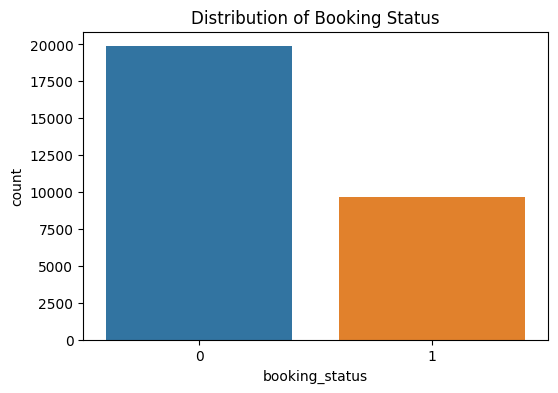

Insight 1:The dataset shows a moderate class imbalance, with approximately two-thirds of bookings not cancelled and one-third cancelled. This reflects typical hotel booking behaviour and provides enough examples of both classes for effective modelling.


In [21]:
# Visualization 1: Distribution of Booking Status
plt.figure(figsize=(6,4))
sns.countplot(x='booking_status', data=train_df)
plt.title('Distribution of Booking Status')
plt.show()
print("Insight 1:The dataset shows a moderate class imbalance, with approximately two-thirds of bookings not cancelled and one-third cancelled. This reflects typical hotel booking behaviour and provides enough examples of both classes for effective modelling.")

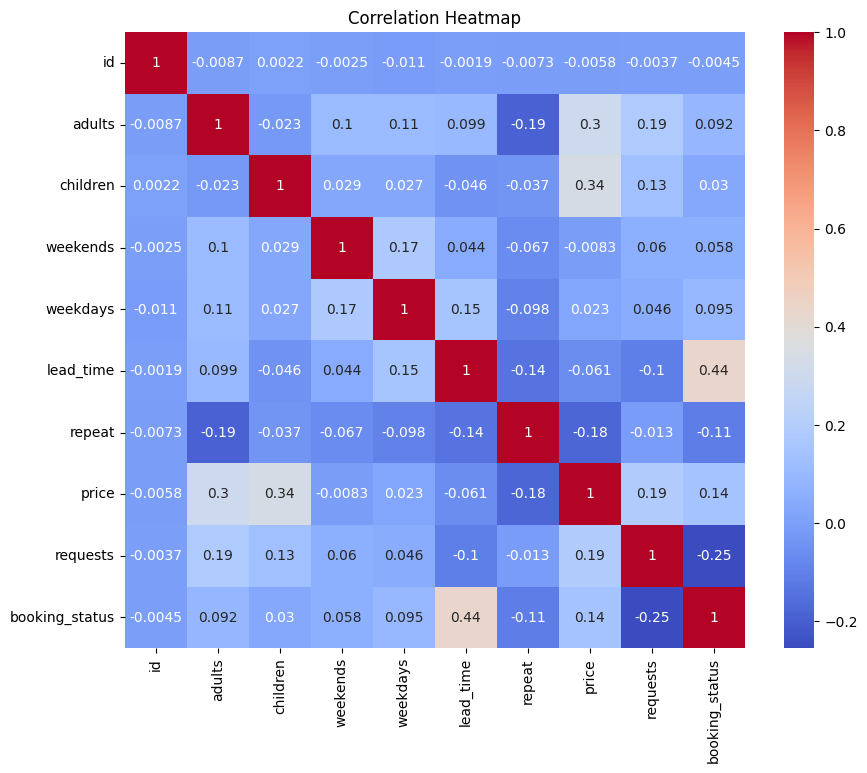

Insight 2: weekends + weekdays may correlate with length-of-stay. Highly correlated features can be combined or one can be dropped for 
simpler models.
Lead_time shows positive correlation with booking status :
This means:Customers who book far in advance are more likely to cancel.Long-term plans have more uncertainty → higher cancellation.


In [22]:
# Visualization 2: Correlation Heatmap (numerical features)
plt.figure(figsize=(10,8))
sns.heatmap(train_df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
print("Insight 2: weekends + weekdays may correlate with length-of-stay. Highly correlated features can be combined or one can be dropped for \nsimpler models.\nLead_time shows positive correlation with booking status :")
print("This means:Customers who book far in advance are more likely to cancel.Long-term plans have more uncertainty → higher cancellation.")

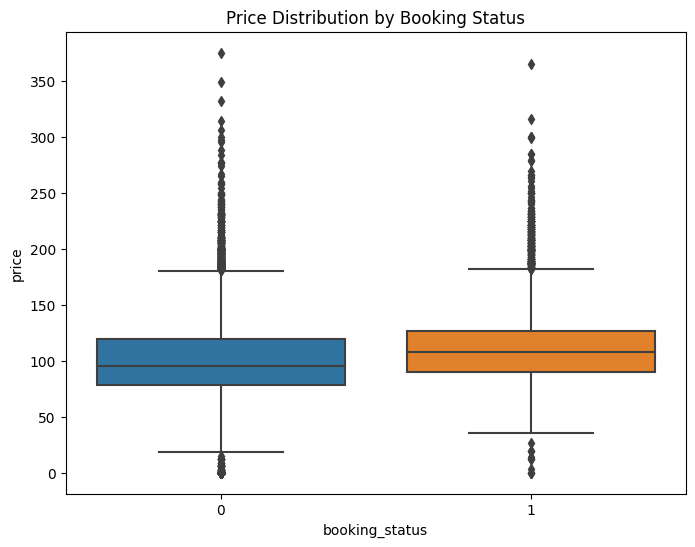

Insight 3:The median price for cancelled bookings is higher than the median price for non-cancelled bookings.
This suggests that:
Customers paying higher prices may be more likely to cancel, possibly due to:
->change of plans,
->switching to cheaper options,
->uncertain travel for expensive stays.


In [23]:
# Visualization 3: Boxplot of Price by Booking Status
plt.figure(figsize=(8,6))
sns.boxplot(x='booking_status', y='price', data=train_df)
plt.title('Price Distribution by Booking Status')
plt.show()
print("Insight 3:The median price for cancelled bookings is higher than the median price for non-cancelled bookings.\nThis suggests that:")
print("Customers paying higher prices may be more likely to cancel, possibly due to:\n->change of plans,\n->switching to cheaper options,\n->uncertain travel for expensive stays.")

### EDA

In [24]:
train_df.head(20)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,adults,children,weekends,weekdays,meal_type,room_type,arrival,lead_time,segment,repeat,price,requests,booking_status
0,0,2,0,0,1,Not Selected,Room_Type 1,2018-05-21,54.0,Online,0,116.10,0,1
1,1,1,0,3,6,Not Selected,Room_Type 1,2018-11-12,12.0,Online,0,71.87,1,1
2,2,2,0,0,2,Meal Plan 1,Room_Type 2,2018-01-06,34.0,Online,0,71.55,1,0
3,3,1,0,2,1,Meal Plan 1,Room_Type 1,2018-02-14,4.0,Corporate,1,66.00,0,0
4,4,2,0,2,3,Meal Plan 1,Room_Type 1,2018-07-08,155.0,Offline,0,72.25,0,0
5,5,2,0,0,3,Meal Plan 1,Room_Type 4,2018-02-16,106.0,Offline,0,46.67,1,0
6,6,2,0,2,3,Not Selected,Room_Type 1,2018-05-12,3.0,Offline,0,96.80,1,0
7,7,1,0,0,1,Meal Plan 1,Room_Type 1,2018-11-09,33.0,Corporate,1,88.00,1,0
8,8,1,0,0,3,Meal Plan 1,Room_Type 1,2018-02-18,15.0,Offline,0,85.33,0,0
9,9,2,0,2,3,Meal Plan 1,NaN,2018-05-14,121.0,Online,0,74.54,0,0


In [25]:
'''# Convert arrival column to datetime
train_df['arrival'] = pd.to_datetime(train_df['arrival'], errors='coerce')

# Create new columns
train_df['arrival_year'] = train_df['arrival'].dt.year
train_df['arrival_month'] = train_df['arrival'].dt.month
train_df['arrival_date'] = train_df['arrival'].dt.day

'''

"# Convert arrival column to datetime\ntrain_df['arrival'] = pd.to_datetime(train_df['arrival'], errors='coerce')\n\n# Create new columns\ntrain_df['arrival_year'] = train_df['arrival'].dt.year\ntrain_df['arrival_month'] = train_df['arrival'].dt.month\ntrain_df['arrival_date'] = train_df['arrival'].dt.day\n\n"

In [26]:
'''# Convert arrival column to datetime
test_df['arrival'] = pd.to_datetime(test_df['arrival'], errors='coerce')

# Create new columns
test_df['arrival_year'] = test_df['arrival'].dt.year
test_df['arrival_month'] = test_df['arrival'].dt.month
test_df['arrival_date'] = test_df['arrival'].dt.day
'''

"# Convert arrival column to datetime\ntest_df['arrival'] = pd.to_datetime(test_df['arrival'], errors='coerce')\n\n# Create new columns\ntest_df['arrival_year'] = test_df['arrival'].dt.year\ntest_df['arrival_month'] = test_df['arrival'].dt.month\ntest_df['arrival_date'] = test_df['arrival'].dt.day\n"

In [27]:
# Create new columns
train_df['arrival_year'] = train_df['arrival'].str[:4]   # Create new column
train_df['arrival_month'] = train_df['arrival'].str[5:7]
train_df['arrival_date'] = train_df['arrival'].str[8:10]


In [28]:
train_df['arrival_year'] = pd.to_numeric(train_df['arrival_year'])
train_df['arrival_month'] = pd.to_numeric(train_df['arrival_month'])
train_df['arrival_date'] = pd.to_numeric(train_df['arrival_date'])


In [29]:
# Create new columns
test_df['arrival_year'] = test_df['arrival'].str[:4]   # Create new column
test_df['arrival_month'] = test_df['arrival'].str[5:7]
test_df['arrival_date'] = test_df['arrival'].str[8:10]


In [30]:
test_df['arrival_year'] = pd.to_numeric(test_df['arrival_year'])
test_df['arrival_month'] = pd.to_numeric(test_df['arrival_month'])
test_df['arrival_date'] = pd.to_numeric(test_df['arrival_date'])

In [31]:
train_df.isnull().sum()

id                   0
adults               0
children             0
weekends             0
weekdays             0
meal_type            0
room_type          841
arrival              0
lead_time         1695
segment              0
repeat               0
price             1583
requests             0
booking_status       0
arrival_year         0
arrival_month        0
arrival_date         0
dtype: int64

In [32]:
train_df.drop('arrival',axis =1,inplace=True)
test_df.drop('arrival',axis =1,inplace=True)

### Train-Test Split

In [33]:
train_df.drop('id',axis=1,inplace=True)

In [34]:
X=train_df.drop('booking_status',axis=1)
y=train_df['booking_status']

In [35]:
X_test= test_df

In [36]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [37]:
numerical_cols

['adults',
 'children',
 'weekends',
 'weekdays',
 'lead_time',
 'repeat',
 'price',
 'requests',
 'arrival_year',
 'arrival_month',
 'arrival_date']

In [38]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

In [39]:
categorical_cols


['meal_type', 'room_type', 'segment']

In [40]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [41]:
X_train.shape

(23600, 14)

In [42]:
X_test.shape

(7000, 15)

### Data Pre-Processing

In [43]:
imputer_transformer = ColumnTransformer([
    ('median_imputer', SimpleImputer(strategy='median',missing_values=np.nan),['lead_time','price']),
    ('mode_imputer',SimpleImputer(strategy='most_frequent',missing_values=np.nan),['room_type'])],remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')
cat_transformer = ColumnTransformer([('ohe',OneHotEncoder(sparse_output=False),['meal_type','room_type','segment'])],remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')
num_transformer = ColumnTransformer([('scaler',StandardScaler(), 
        numerical_cols )],remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')

In [44]:
'''num_pipeline = Pipeline([('median',SimpleImputer(strategy = 'median',missing_values = np.nan)),('scaler',StandardScaler())])
cat_pipeline = Pipeline([('ohe', OneHotEncoder(sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_cols), 
        ('cat', cat_pipeline, categorical_cols)
    ], remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')
'''

"num_pipeline = Pipeline([('median',SimpleImputer(strategy = 'median',missing_values = np.nan)),('scaler',StandardScaler())])\ncat_pipeline = Pipeline([('ohe', OneHotEncoder(sparse_output=False))])\n\npreprocessor = ColumnTransformer(\n    transformers=[\n        ('num', num_pipeline, numerical_cols), \n        ('cat', cat_pipeline, categorical_cols)\n    ], remainder='passthrough',verbose_feature_names_out=False).set_output(transform='pandas')\n"

In [45]:
preprocessor=Pipeline([
        ('imp', imputer_transformer),
        ('enc', cat_transformer),
        ('scale',num_transformer)]).set_output(transform='pandas')

In [46]:
preprocessor.fit(X_train,y_train)

Pipeline(steps=[('imp',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('median_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['lead_time', 'price']),
                                                 ('mode_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['room_type'])],
                                   verbose_feature_names_out=False)),
                ('enc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['meal_type', 'room_type',
                                                   'segment'])],
                                   verbose_feature_names_out=False)),
                ('scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['adults', 'children',
                                                   'weekends', 'weekdays',
                                                   'lead_time', 'repeat',
                                                   'price', 'requests',
                                                   'arrival_year',
                                                   'arrival_month',
                                                   'arrival_date'])],
                                   verbose_feature_names_out=False))])

In [47]:
X_train_trans = preprocessor.transform(X_train)

In [48]:
X_train_trans.isnull().sum()

adults                    0
children                  0
weekends                  0
weekdays                  0
lead_time                 0
repeat                    0
price                     0
requests                  0
arrival_year              0
arrival_month             0
arrival_date              0
meal_type_Meal Plan 1     0
meal_type_Meal Plan 2     0
meal_type_Meal Plan 3     0
meal_type_Not Selected    0
room_type_Room_Type 1     0
room_type_Room_Type 2     0
room_type_Room_Type 3     0
room_type_Room_Type 4     0
room_type_Room_Type 5     0
room_type_Room_Type 6     0
room_type_Room_Type 7     0
segment_Aviation          0
segment_Complementary     0
segment_Corporate         0
segment_Offline           0
segment_Online            0
dtype: int64

In [49]:
X_train_trans['arrival_year'].unique()

array([-2.13898157,  0.46751221])

In [50]:
X_vali=preprocessor.transform(X_val)

In [51]:
X_vali.columns

Index(['adults', 'children', 'weekends', 'weekdays', 'lead_time', 'repeat',
       'price', 'requests', 'arrival_year', 'arrival_month', 'arrival_date',
       'meal_type_Meal Plan 1', 'meal_type_Meal Plan 2',
       'meal_type_Meal Plan 3', 'meal_type_Not Selected',
       'room_type_Room_Type 1', 'room_type_Room_Type 2',
       'room_type_Room_Type 3', 'room_type_Room_Type 4',
       'room_type_Room_Type 5', 'room_type_Room_Type 6',
       'room_type_Room_Type 7', 'segment_Aviation', 'segment_Complementary',
       'segment_Corporate', 'segment_Offline', 'segment_Online'],
      dtype='object')

In [52]:
X_test_trans = preprocessor.transform(X_test)

In [53]:
X_test_trans.columns

Index(['adults', 'children', 'weekends', 'weekdays', 'lead_time', 'repeat',
       'price', 'requests', 'arrival_year', 'arrival_month', 'arrival_date',
       'meal_type_Meal Plan 1', 'meal_type_Meal Plan 2',
       'meal_type_Meal Plan 3', 'meal_type_Not Selected',
       'room_type_Room_Type 1', 'room_type_Room_Type 2',
       'room_type_Room_Type 3', 'room_type_Room_Type 4',
       'room_type_Room_Type 5', 'room_type_Room_Type 6',
       'room_type_Room_Type 7', 'segment_Aviation', 'segment_Complementary',
       'segment_Corporate', 'segment_Offline', 'segment_Online'],
      dtype='object')

### Model Building

In [54]:
'''model_metric = {}
fitted_model = {}

models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "Neural Network (MLP)": MLPClassifier(random_state=42, max_iter=500)
}
results={}'''

'model_metric = {}\nfitted_model = {}\n\nmodels = {\n    "Logistic Regression": LogisticRegression(random_state=42),\n    "K-Nearest Neighbors": KNeighborsClassifier(),\n    "Gaussian Naive Bayes": GaussianNB(),\n    "Decision Tree": DecisionTreeClassifier(random_state=42),\n    "Random Forest": RandomForestClassifier(random_state=42),\n    "LightGBM": lgb.LGBMClassifier(random_state=42),\n    "Neural Network (MLP)": MLPClassifier(random_state=42, max_iter=500)\n}\nresults={}'

In [55]:
# 3. Models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "Neural Network (MLP)": MLPClassifier(random_state=42, max_iter=500)
}
results = {}
fitted_model={}
for name, model in models.items():
    print(f"---Training {name}---")
    model.fit(X_train_trans, y_train)
    fitted_model[name] = model
    
    y_pred = model.predict(X_vali)
    y_pred_proba = model.predict_proba(X_vali)[:, 1]

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    results[name] = {'Accuracy': accuracy, 'F1-Score': f1, 'ROC-AUC': roc_auc}
    print(f"{name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}\n")

results_df = pd.DataFrame(results).T.sort_values(by='F1-Score', ascending=False)
print("\n Model Performance Comparison")
print(results_df)


---Training Logistic Regression---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Accuracy: 0.7890
F1-Score: 0.6446
ROC-AUC: 0.8346

---Training K-Nearest Neighbors---
K-Nearest Neighbors
Accuracy: 0.8322
F1-Score: 0.7327
ROC-AUC: 0.8786

---Training Gaussian Naive Bayes---
Gaussian Naive Bayes
Accuracy: 0.3898
F1-Score: 0.5073
ROC-AUC: 0.7740

---Training Decision Tree---
Decision Tree
Accuracy: 0.8514
F1-Score: 0.7737
ROC-AUC: 0.8361

---Training Random Forest---
Random Forest
Accuracy: 0.8883
F1-Score: 0.8184
ROC-AUC: 0.9412

---Training LightGBM---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7715, number of negative: 15885
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 23600, number of used features: 25
[

### Hyper Parameter Tuning

#### Tuning on LightGBM

In [56]:
from sklearn.model_selection import RandomizedSearchCV
print("Tuning LightGBM")
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', lgb.LGBMClassifier(random_state=42))
])
param_grid_lgbm = {
    'classifier__n_estimators': [100, 200, 500, 700],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [20, 31, 40, 50],
    'classifier__max_depth': [10, 15, -1],
    'classifier__reg_alpha': [0.1, 0.5, 1.0],
    'classifier__reg_lambda': [0.1, 0.5, 1.0]
}
lgbm_search = RandomizedSearchCV(
    lgbm_pipeline, 
    param_grid_lgbm, 
    n_iter=15, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1, 
    random_state=42
)
lgbm_search.fit(X_train, y_train)
print(f"Best F1-Score for LightGBM: {lgbm_search.best_score_:.4f}")
print(lgbm_search.best_params_)


Tuning LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5143, number of negative: 10590
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 15733, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.326893 -> initscore=-0.722274
[LightGBM] [Info] Start training from score -0.722274
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5143, number of negative: 10590
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

#### Tuning on RandomForest

In [57]:

print("\nTuning Random Forest")
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', RandomForestClassifier(random_state=42))
])
param_grid_rf = {
    'classifier__n_estimators': np.arange(100, 301, 10),                # Sample between 100 and 300 in steps of 10
    'classifier__max_depth': [8, 10, 15, 20, None],                    # You can add more values, or use np.arange(8, 21)
    'classifier__min_samples_split': np.arange(2, 11),                 # Sample splits between 2 and 10
    'classifier__min_samples_leaf': np.arange(1, 5),                   # Sample leaves between 1 and 4
    'classifier__class_weight': ['balanced'],                          # Helpful for F1 on imbalanced data
    'classifier__max_features': ['sqrt', 'log2', None]
}
rf_search = RandomizedSearchCV(
    rf_pipeline, 
    param_grid_rf, 
    n_iter=15, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1, 
    random_state=42
)
rf_search.fit(X_train, y_train)
print(f"Best F1-Score for Random Forest: {rf_search.best_score_:.4f}")

print(rf_search.best_params_)


Tuning Random Forest
Best F1-Score for Random Forest: 0.8136
{'classifier__n_estimators': 160, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': None, 'classifier__max_depth': 20, 'classifier__class_weight': 'balanced'}


#### Tuning on MLP

In [58]:
'''print("\nTuning Neural Network (MLP)")
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', MLPClassifier(random_state=42, early_stopping=True, n_iter_no_change=15))
])
param_grid_mlp = {
    'classifier__hidden_layer_sizes': [(100, 50), (100,), (50, 30), (150, 100, 50)],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate_init': [0.001, 0.01],
    'classifier__max_iter': [1200]
}
mlp_search = RandomizedSearchCV(
    mlp_pipeline, 
    param_grid_mlp, 
    n_iter=15, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1, 
    random_state=42
)
mlp_search.fit(X_train, y_train)
print(f"Best F1-Score for Neural Network (MLP): {mlp_search.best_score_:.4f}")'''

'print("\nTuning Neural Network (MLP)")\nmlp_pipeline = Pipeline(steps=[\n    (\'preprocessor\', preprocessor), \n    (\'classifier\', MLPClassifier(random_state=42, early_stopping=True, n_iter_no_change=15))\n])\nparam_grid_mlp = {\n    \'classifier__hidden_layer_sizes\': [(100, 50), (100,), (50, 30), (150, 100, 50)],\n    \'classifier__alpha\': [0.0001, 0.001, 0.01],\n    \'classifier__learning_rate_init\': [0.001, 0.01],\n    \'classifier__max_iter\': [1200]\n}\nmlp_search = RandomizedSearchCV(\n    mlp_pipeline, \n    param_grid_mlp, \n    n_iter=15, \n    cv=3, \n    scoring=\'f1\', \n    n_jobs=-1, \n    random_state=42\n)\nmlp_search.fit(X_train, y_train)\nprint(f"Best F1-Score for Neural Network (MLP): {mlp_search.best_score_:.4f}")'

In [59]:
import pandas as pd

# Collect model results here
results = []

# Random Forest tuned model
results.append({
    "Model": "Random Forest",
    "Best F1-Score (CV)": rf_search.best_score_,
    "Best Params": rf_search.best_params_
})

# Add your other models here ↓↓↓
# Example:
'''results.append({
    "Model": "MLP",
    "Best F1-Score (CV)": mlp_search.best_score_,
    "Best Params": mlp_search.best_params_
})'''

results.append({
    "Model": "LightGBM",
    "Best F1-Score (CV)": lgbm_search.best_score_,
    "Best Params": lgbm_search.best_params_
})

# Convert to DataFrame
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values(by="Best F1-Score (CV)", ascending=False)


# Display neatly
print("\nModel Comparison:")
display(comparison_df)



Model Comparison:


,Model,Best F1-Score (CV),Best Params
0,Random Forest,0.813576,"{'classifier__n_estimators': 160, 'classifier_..."
1,LightGBM,0.812936,"{'classifier__reg_lambda': 0.5, 'classifier__r..."


**The best model is Random Forest Classifier (not tuned) with an F1 score of 0.8171.**

In [60]:
best_model = RandomForestClassifier(random_state=42)


In [61]:
full_x = pd.concat([X_train_trans,X_vali], axis=0)
full_y = pd.concat([y_train, y_val], axis=0)


In [62]:
full_x.columns

Index(['adults', 'children', 'weekends', 'weekdays', 'lead_time', 'repeat',
       'price', 'requests', 'arrival_year', 'arrival_month', 'arrival_date',
       'meal_type_Meal Plan 1', 'meal_type_Meal Plan 2',
       'meal_type_Meal Plan 3', 'meal_type_Not Selected',
       'room_type_Room_Type 1', 'room_type_Room_Type 2',
       'room_type_Room_Type 3', 'room_type_Room_Type 4',
       'room_type_Room_Type 5', 'room_type_Room_Type 6',
       'room_type_Room_Type 7', 'segment_Aviation', 'segment_Complementary',
       'segment_Corporate', 'segment_Offline', 'segment_Online'],
      dtype='object')

In [63]:
best_model.fit(full_x, full_y)


RandomForestClassifier(random_state=42)

In [64]:
test_pred = best_model.predict(X_test_trans)
test_pred = np.clip(test_pred, 0, None)

In [65]:
submission = pd.DataFrame({
    "id": range(X_test_trans.shape[0]),
    "booking_status": test_pred
})
submission.to_csv("submission.csv", index=False)
submission

,id,booking_status
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0
...,...,...
6995,6995,1
6996,6996,0
6997,6997,0
6998,6998,0


In [66]:
'''# Replace "Not Selected" with 0
test_df['meal_type'] = test_df['meal_type'].replace("Not Selected", 0)

# Extract digits from the remaining values (Meal Plan 1 → 1, Meal Plan 2 → 2, etc.)
test_df['meal_type'] = test_df['meal_type'].astype(str).str.extract(r'(\d+)', expand=False)

# Convert to numeric, keeping 0 as 0
test_df['meal_type'] = pd.to_numeric(test_df['meal_type'], errors='coerce').fillna(0).astype(int)
test_df['room_type'] = test_df['room_type'].str.extract(r'(\d+)', expand=False)
test_df['room_type'] = pd.to_numeric(test_df['room_type'], errors ='coerce')'''

'# Replace "Not Selected" with 0\ntest_df[\'meal_type\'] = test_df[\'meal_type\'].replace("Not Selected", 0)\n\n# Extract digits from the remaining values (Meal Plan 1 → 1, Meal Plan 2 → 2, etc.)\ntest_df[\'meal_type\'] = test_df[\'meal_type\'].astype(str).str.extract(r\'(\\d+)\', expand=False)\n\n# Convert to numeric, keeping 0 as 0\ntest_df[\'meal_type\'] = pd.to_numeric(test_df[\'meal_type\'], errors=\'coerce\').fillna(0).astype(int)\ntest_df[\'room_type\'] = test_df[\'room_type\'].str.extract(r\'(\\d+)\', expand=False)\ntest_df[\'room_type\'] = pd.to_numeric(test_df[\'room_type\'], errors =\'coerce\')'